In [1]:
from google.colab import drive

drive.mount('/content/gdrive')
DIR = "/content/gdrive/My Drive/"


import os
os.chdir(DIR+"Career/Projects/Deep Learning Nanodegree/face_generation")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
! ls

data				     helper.py
dlnd_face_generation.ipynb	     problem_unittests.py
dlnd_face_generation_ORIGINAL.ipynb  __pycache__


# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [3]:
! ls data

celeba.zip  img_align_celeba  mnist  train-images-idx3-ubyte.gz


In [4]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir) # takes half an hour
helper.download_extract('celeba', data_dir) # takes two hours 

Found mnist Data
Found celeba Data


In [5]:
! ls data

celeba.zip  img_align_celeba  mnist  train-images-idx3-ubyte.gz


# VITAL NOTE

Before going on to the project, we need to hold up some time for the system to load the images.

The following cell should return something close to the following values:
```
56933
110386
```
If it doesn't return that, hold up about 30 minutes and then try again. 

**DON't PROCEEED UNTIL THE DATA IS FULLY LOADED**

In [9]:
from glob import glob


print( len(glob(os.path.join(data_dir, 'mnist/*.jpg'))) )
print( len(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))))

56933
110386


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

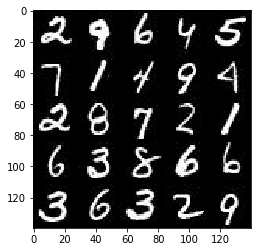

In [10]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

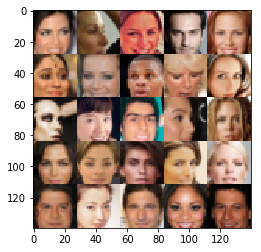

In [11]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [12]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.14.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [13]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_ = tf.placeholder(shape=(None, image_width, image_height, image_channels), dtype=tf.float32)
    z = tf.placeholder(shape=(None, z_dim), dtype=tf.float32)
    learning_rate = tf.placeholder(shape=None, dtype=tf.float32)

    return input_, z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

W0725 07:10:59.026257 140471325058944 deprecation_wrapper.py:119] From /content/gdrive/My Drive/Career/Projects/Deep Learning Nanodegree/face_generation/problem_unittests.py:20: The name tf.assert_rank is deprecated. Please use tf.compat.v1.assert_rank instead.



Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [14]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    _, WIDTH, HEIGHT, DEPTH = images.shape # Input Layer is 28x28x1 in case of mnist and 28x28x3
    alpha = 0.2 
    filters = [64, 128]
    with tf.variable_scope('discriminator', reuse=reuse):
        
        # First Layer
        x1 = tf.layers.conv2d(images, filters=64, kernel_size=(5,5), strides=(2,2), padding='same')
        x1 = tf.layers.batch_normalization(x1, training=True)
        x1 = tf.math.maximum(x1, x1*alpha) #Leaky ReLU
        # Now, it's 14x14x64
        
        # Second Layer
        x2 = tf.layers.conv2d(x1, filters=128, kernel_size=(5,5), strides=(2,2), padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.math.maximum(x2, x2*alpha) #Leaky ReLU
        # Now, it's 7x7x128
        
        # Output
        flat = tf.reshape(x2, (-1, 7*7*filters[-1])) # now, its shape is (None, 1024)
        logits = tf.layers.dense(flat, 1)
        out = tf.math.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

W0725 07:10:59.067209 140471325058944 deprecation_wrapper.py:119] From /content/gdrive/My Drive/Career/Projects/Deep Learning Nanodegree/face_generation/problem_unittests.py:46: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W0725 07:10:59.068949 140471325058944 deprecation_wrapper.py:119] From /content/gdrive/My Drive/Career/Projects/Deep Learning Nanodegree/face_generation/problem_unittests.py:74: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0725 07:10:59.076834 140471325058944 deprecation.py:323] From <ipython-input-14-d25124188d05>:15: conv2d (from tensorflow.python.layers.convolutional) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
W0725 07:10:59.083362 140471325058944 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.pyth

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [15]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    reuse = not is_train
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x = tf.layers.dense(z, 7*7*128)
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.reshape(x, shape=(-1, 7, 7, 128))
        # Now, it's 7x7x256
        
        # First Layer
        x1 = tf.layers.conv2d_transpose(x, filters=64, kernel_size=(5, 5), strides=(2, 2), padding='same')
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.math.maximum(x1, x1*alpha) #Leaky ReLU
        # Now, it's 14x14x128
        
#         # Second Layer
#         x2 = tf.layers.conv2d_transpose(x1, filters=64, kernel_size=(5, 5), strides=(2, 2), padding='same')
#         x2 = tf.layers.batch_normalization(x2, training=is_train)
#         x2 = tf.math.maximum(x2, x2*alpha) #Leaky ReLU
#         # Now, it's 28x28x64
        
#         # Third Layer
#         x3 = tf.layers.conv2d_transpose(x2, filters=64, kernel_size=(5, 5), strides=(2, 2), padding='same')
#         x3 = tf.layers.batch_normalization(x3, training=training)
#         x3 = tf.math.maximum(x3, x3*alpha) #Leaky ReLU
#         # Now, it's 32x32x64
        
        # Output layer, 32x32x3
        logits = tf.layers.conv2d_transpose(x1, filters=out_channel_dim, kernel_size=(5, 5), strides=(2, 2), padding='same')
        
        out = tf.tanh(logits)
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

W0725 07:11:00.916121 140471325058944 deprecation.py:323] From <ipython-input-15-3a32e890c448>:20: conv2d_transpose (from tensorflow.python.layers.convolutional) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.keras.layers.Conv2DTranspose` instead.


Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [16]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

W0725 07:11:02.008224 140471325058944 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [17]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

W0725 07:11:02.051027 140471325058944 deprecation_wrapper.py:119] From /content/gdrive/My Drive/Career/Projects/Deep Learning Nanodegree/face_generation/problem_unittests.py:46: The name tf.trainable_variables is deprecated. Please use tf.compat.v1.trainable_variables instead.



Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [0]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [0]:
from tqdm import tqdm_notebook as tqdm


def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
       
    # Get image dims
    total_images, image_width, image_height, image_channels = data_shape

    # Create optimizers
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)

    # Create model saver
#     saver = tf.train.Saver()
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_idx, batch_images in tqdm(enumerate(get_batches(batch_size)), desc="Processing", total=total_images//batch_size):
                # Sample random noise for Generator network
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # I'm using tanh in the generator's last layer,
                # so the values in generated images will be in the range [-1,1], however the values in batch_images
                # here are in the range [-0.5, 0.5].
                # Hence you need to scale these values by using batch_images=batch_images*2.
                batch_images = batch_images*2
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate})
                
                # Show some results
                if batch_idx % 100 == 0:
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)
                
                if batch_idx % 20==0:
                    # Show losses
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

#         saver.save(sess, './checkpoints/generator.ckpt')   
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Dataset shape: (56933, 28, 28, 1)
Image mode: L


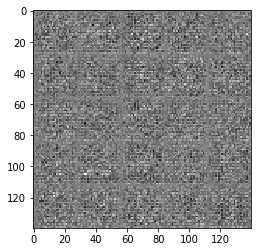

Epoch 1/2... Discriminator Loss: 4.7733... Generator Loss: 0.0282
Epoch 1/2... Discriminator Loss: 0.0520... Generator Loss: 3.9215
Epoch 1/2... Discriminator Loss: 0.0277... Generator Loss: 4.9713
Epoch 1/2... Discriminator Loss: 0.0105... Generator Loss: 6.0216
Epoch 1/2... Discriminator Loss: 0.0046... Generator Loss: 6.9377


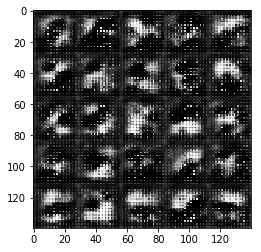

Epoch 1/2... Discriminator Loss: 0.0498... Generator Loss: 4.5573
Epoch 1/2... Discriminator Loss: 0.2232... Generator Loss: 4.5686
Epoch 1/2... Discriminator Loss: 0.2383... Generator Loss: 2.6138
Epoch 1/2... Discriminator Loss: 0.4710... Generator Loss: 5.4229
Epoch 1/2... Discriminator Loss: 0.4214... Generator Loss: 2.4236


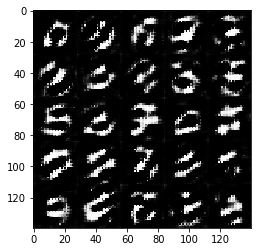

Epoch 1/2... Discriminator Loss: 0.1082... Generator Loss: 3.6227
Epoch 1/2... Discriminator Loss: 0.5002... Generator Loss: 2.2129
Epoch 1/2... Discriminator Loss: 0.5481... Generator Loss: 2.9216
Epoch 1/2... Discriminator Loss: 0.6899... Generator Loss: 1.7902
Epoch 1/2... Discriminator Loss: 0.5718... Generator Loss: 2.1071


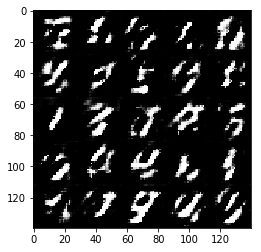

Epoch 1/2... Discriminator Loss: 0.3385... Generator Loss: 2.3107
Epoch 1/2... Discriminator Loss: 0.2188... Generator Loss: 3.0016
Epoch 1/2... Discriminator Loss: 0.0972... Generator Loss: 3.3849
Epoch 1/2... Discriminator Loss: 0.1606... Generator Loss: 4.3896
Epoch 1/2... Discriminator Loss: 0.1268... Generator Loss: 5.6140


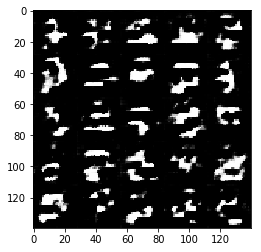

Epoch 1/2... Discriminator Loss: 0.1320... Generator Loss: 3.8074


In [0]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.9

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
print("Dataset shape:", mnist_dataset.shape)
print("Image mode:", mnist_dataset.image_mode)

# Reset the default graph just in case!
tf.reset_default_graph()


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

In [0]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.9

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
print("Dataset shape:", celeba_dataset.shape)
print("Image mode:", celeba_dataset.image_mode)

# Reset the default graph just in case!
tf.reset_default_graph()


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1,
          celeba_dataset.get_batches, celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.